

# Credit Card Fraud Detection
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Additional Learning/Things to do:
* How to deal with the unbalanced Data - when the number of fraud is less as compared to no fraud, what metric to use- Matthew correlation
* Precision and Recall- which is important here
* Entirely Data, features not mentioned, so feature selection not useful. 
* More details on the visualisation: https://github.com/jgcorliss/credit-card-fraud/blob/master/Credit%20Card%20Fraud%20Detection.ipynb
Performance Enhancements
1) One models
2) Many Model
3) Grid

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2)
    * [4.3.Data Transformation](#3.3) 
        * [4.3.1 Rescaling ](#3.3.1)
        * [4.3.2 Standardization](#3.3.2)
        * [4.3.3 Normalization](#3.3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Common Classification Models](#4.3.1)
        * [5.3.2 Ensemble Models](#4.3.2)
        * [5.3.3 Deep Learning Models](#4.3.3)    
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Definition

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

1. The features are mostly PC components(28 out of 30) which we can neither name nor engineer with. 
2. Since the dataset is highly imbalanced, using accuracy as evaluation metric is not a clever idea, the performance metrics should be Confusion Matrix and PR(precision-recall) curve, or maybe Area under PR curve if a single-number metric is needed.
3. We should not predict hard labels(0 or 1) at first place but probabilities instead, since the default 0.5 cutoff for labeling might not be suitable for imbalanced dataset.
4. As a brain refresher, Precision evaluates how many selected items are relevant, while Recall evaluates how many relevant items are selected.
5. The train set is used to train model and model tuning, the validation set is used to evaluate on PR curve and choosing threshold, while the test set is only used for final prediction. 


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

Using TensorFlow backend.


<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
# load dataset
dataset = read_csv('creditcard.csv')

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [5]:
# shape
dataset.shape

(284807, 31)

In [13]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [8]:
# describe data
set_option('precision', 3)
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,...,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,2.848e+05,284807.000,284807.000
mean,94813.860,3.920e-15,5.688e-16,-8.769e-15,2.782e-15,-1.553e-15,2.011e-15,-1.694e-15,-1.927e-16,-3.137e-15,...,1.537e-16,7.960e-16,5.368e-16,4.458e-15,1.453e-15,1.699e-15,-3.660e-16,-1.206e-16,88.350,0.002
std,47488.146,1.959e+00,1.651e+00,1.516e+00,1.416e+00,1.380e+00,1.332e+00,1.237e+00,1.194e+00,1.099e+00,...,7.345e-01,7.257e-01,6.245e-01,6.056e-01,5.213e-01,4.822e-01,4.036e-01,3.301e-01,250.120,0.042
min,0.000,-5.641e+01,-7.272e+01,-4.833e+01,-5.683e+00,-1.137e+02,-2.616e+01,-4.356e+01,-7.322e+01,-1.343e+01,...,-3.483e+01,-1.093e+01,-4.481e+01,-2.837e+00,-1.030e+01,-2.605e+00,-2.257e+01,-1.543e+01,0.000,0.000
25%,54201.500,-9.204e-01,-5.985e-01,-8.904e-01,-8.486e-01,-6.916e-01,-7.683e-01,-5.541e-01,-2.086e-01,-6.431e-01,...,-2.284e-01,-5.424e-01,-1.618e-01,-3.546e-01,-3.171e-01,-3.270e-01,-7.084e-02,-5.296e-02,5.600,0.000
50%,84692.000,1.811e-02,6.549e-02,1.798e-01,-1.985e-02,-5.434e-02,-2.742e-01,4.010e-02,2.236e-02,-5.143e-02,...,-2.945e-02,6.782e-03,-1.119e-02,4.098e-02,1.659e-02,-5.214e-02,1.342e-03,1.124e-02,22.000,0.000
75%,139320.500,1.316e+00,8.037e-01,1.027e+00,7.433e-01,6.119e-01,3.986e-01,5.704e-01,3.273e-01,5.971e-01,...,1.864e-01,5.286e-01,1.476e-01,4.395e-01,3.507e-01,2.410e-01,9.105e-02,7.828e-02,77.165,0.000
max,172792.000,2.455e+00,2.206e+01,9.383e+00,1.688e+01,3.480e+01,7.330e+01,1.206e+02,2.001e+01,1.559e+01,...,2.720e+01,1.050e+01,2.253e+01,4.585e+00,7.520e+00,3.517e+00,3.161e+01,3.385e+01,25691.160,1.000


How many are fraud and how many are not fraud ?

In [9]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


<a id='2.2'></a>
## 3.2. Data Visualization

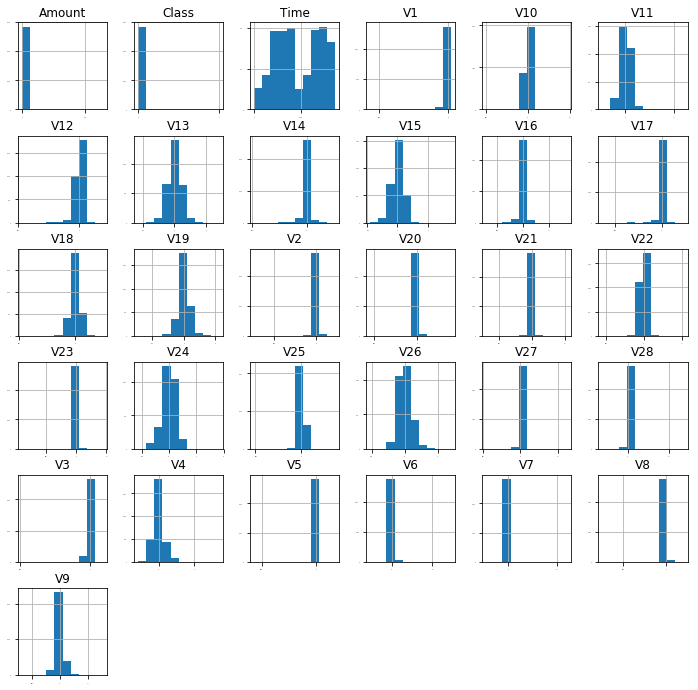

In [14]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

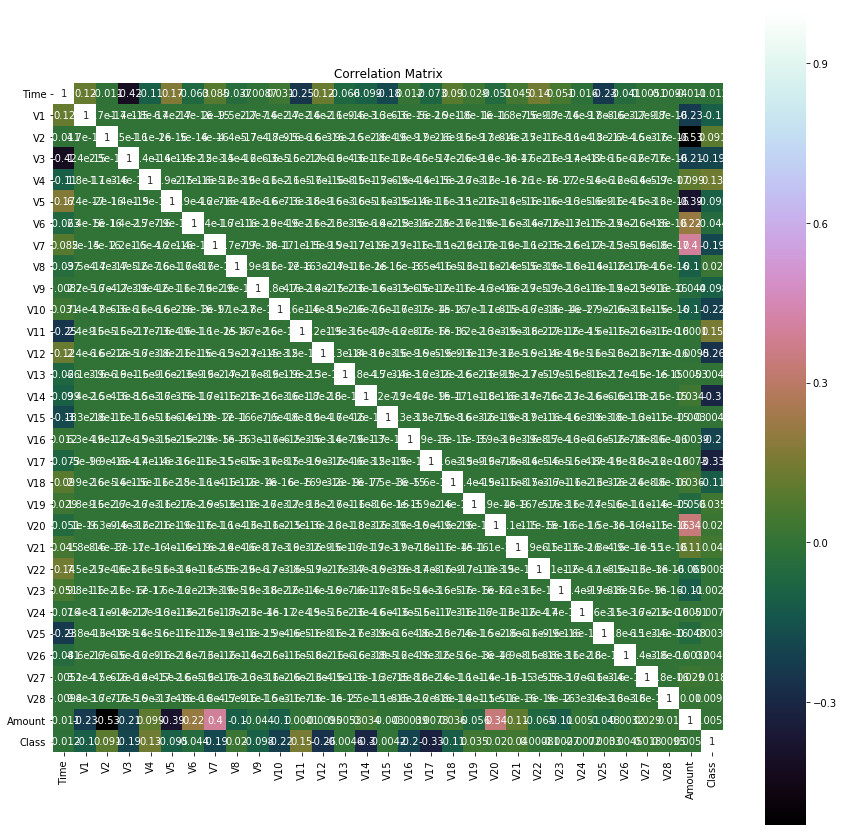

In [19]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Significant Correlation most of the areas are green or black.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [25]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are no null values, the next step is not performed

In [26]:
# Drop the rows containing NA
#dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())

<a id='3.2'></a>
## 4.2. Handling Categorical Data

In [24]:
#There is no categorical Data, so it doen't need to be handled. 

<a id='3.2'></a>
## 4.2. Feature Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.
The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Dataset.

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10)
bestfeatures

SelectKBest(k=10, score_func=<function f_classif at 0x0000015B562C3510>)

In [38]:
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs         Score
17   V17  33979.168593
14   V14  28695.547788
12   V12  20749.822361
10   V10  14057.979985
16   V16  11443.349428
3     V3  11014.508305
7     V7  10349.605408
11   V11   6999.355047
4     V4   5163.832114
18   V18   3584.380605


As it can be seem from the numbers above Credit Amount is the most important feature followed by duration.

<a id='3.3'></a>
## 4.3. Data Transformation

<a id='3.3.1'></a>
### 4.3.1. Data Standardisation
Data Standardisation is performed later during the model tuning process.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [4]:
# split out validation dataset for the end
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [5]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1. Common Models

In [6]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))

<a id='4.3.2'></a>
### 5.3.2. Ensemble Models

In [17]:
# #Ensable Models 
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

<a id='4.3.3'></a>
### 5.3.3. Deep Learning Model

In [18]:
#Writing the Deep Learning Classifier in case the Deep Learning Flag is Set to True
#Set the following Flag to 1 if the Deep LEarning Models Flag has to be enabled
EnableDLModelsFlag = 0
if EnableDLModelsFlag == 1 :   
    # Function to create model, required for KerasClassifier
    def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(2, activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model    
    models.append(('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)))

### K-folds cross validation

In [7]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998942 (0.000229)


### Algorithm comparison

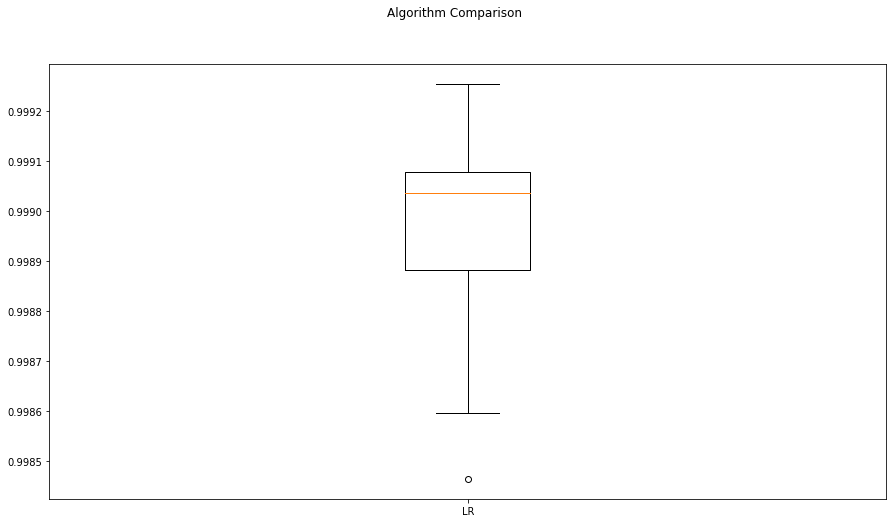

In [8]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

<a id='H5'></a>
# Postprocessing the data : Data Standardisation

In [9]:
# standardized the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
# pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
# pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
# pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
# pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))
# pipelines.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()), ('CART', AdaBoostClassifier())])))
# pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingClassifier())])))
# pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
# pipelines.append(('ScaledET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesClassifier())])))
# pipelines.append(('ScaledNN', Pipeline([('Scaler', StandardScaler()), ('NN', MLPClassifier())])))
# pipelines.append(('ScaledDNN', Pipeline([('Scaler', StandardScaler()), ('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0))])))

In [10]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.999188 (0.000180)


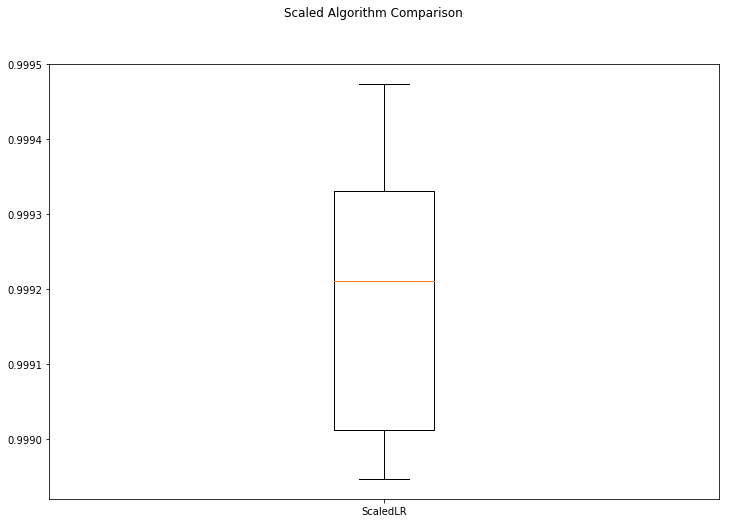

In [14]:
# compare scaled algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(12,8)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Algorithm Tuning: Although some of the models show the most promising options. the grid search for Gradient Bossting Classifier is shown below.

In [12]:
# 1. Grid search : Logistic Regression Algorithm 
'''
penalty : str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’, optional (default=’l2’)

C : float, optional (default=1.0)
Inverse of regularization strength; must be a positive float.Smaller values specify stronger regularization.
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
C= np.logspace(-3,3,7)
penalty = ["l1","l2"]# l1 lasso l2 ridge
param_grid = dict(C=C,penalty=penalty )
model = LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.999188 using {'C': 1.0, 'penalty': 'l1'}
#14 0.998538 (0.000273) with: {'C': 0.001, 'penalty': 'l1'}
#13 0.999061 (0.000199) with: {'C': 0.001, 'penalty': 'l2'}
#12 0.999113 (0.000183) with: {'C': 0.01, 'penalty': 'l1'}
#11 0.999144 (0.000173) with: {'C': 0.01, 'penalty': 'l2'}
#10 0.999179 (0.000194) with: {'C': 0.1, 'penalty': 'l1'}
#9 0.999184 (0.000175) with: {'C': 0.1, 'penalty': 'l2'}
#1 0.999188 (0.000180) with: {'C': 1.0, 'penalty': 'l1'}
#1 0.999188 (0.000180) with: {'C': 1.0, 'penalty': 'l2'}
#1 0.999188 (0.000180) with: {'C': 10.0, 'penalty': 'l1'}
#1 0.999188 (0.000180) with: {'C': 10.0, 'penalty': 'l2'}
#1 0.999188 (0.000180) with: {'C': 100.0, 'penalty': 'l1'}
#1 0.999188 (0.000180) with: {'C': 100.0, 'penalty': 'l2'}
#1 0.999188 (0.000180) with: {'C': 1000.0, 'penalty': 'l1'}
#1 0.999188 (0.000180) with: {'C': 1000.0, 'penalty': 'l2'}


In [ ]:
# Grid Search : LDA Algorithm 
'''
n_components : int, optional (default=None)
Number of components for dimensionality reduction. If None, will be set to min(n_classes - 1, n_features).
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
components  = [1,3,5,7,9,11,13,15,17,19,600]
param_grid = dict(n_components=components)
model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search KNN algorithm tuning
'''
n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for kneighbors queries.

weights : str or callable, optional (default = ‘uniform’)
    weight function used in prediction. Possible values: ‘uniform’, ‘distance’

''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

neighbors = [1,3,5,7,9,11,13,15,17,19,21]
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=neighbors, weights = weights )
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search : CART Algorithm 
'''
max_depth : int or None, optional (default=None)
    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure 
    or until all leaves contain less than min_samples_split samples.

''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
max_depth = np.arange(2, 30)
param_grid = dict(max_depth=max_depth)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search : NB algorithm tuning
#GaussianNB only accepts priors as an argument so unless you have some priors to set for your model ahead of time 
#you will have nothing to grid search over.


In [ ]:
# Grid Search: SVM algorithm tuning
'''
C : float, optional (default=1.0)
Penalty parameter C of the error term.

kernel : string, optional (default=’rbf’)
Specifies the kernel type to be used in the algorithm. 
It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. 
Parameters of SVM are C and kernel. 
Try a number of kernels with various values of C with less bias and more bias (less than and greater than 1.0 respectively
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5]
kernel_values = ['linear', 'poly', 'rbf']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search: Ada boost Algorithm Tuning 
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated. 
    In case of perfect fit, the learning procedure is stopped early.
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [10, 100]
param_grid = dict(n_estimators=n_estimators)
model = AdaBoostClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search: ExtraTreesClassifier()
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = ExtraTreesClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search : NN algorithm tuning
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith hidden layer.
Other Parameters that can be tuned
    learning_rate_init : double, optional, default 0.001
        The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
    max_iter : int, optional, default 200
        Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
hidden_layer_sizes=[(20,), (50,), (20,20), (20, 30, 20)]
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes)
model = MLPClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# Grid Search : Deep Neural Network algorithm tuning
'''
neurons: int
    Number of patterns shown to the network before the weights are updated.     
batch_size: int
    Number of observation to read at a time and keep in memory.
epochs: int
    Number of times that the entire training dataset is shown to the network during training.
activation:
    The activation function controls the non-linearity of individual neurons and when to fire.
learn_rate :int
    controls how much to update the weight at the end of each batch
momentum : int
     momentum controls how much to let the previous update influence the current weight update
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
#Hyperparameters that can be modified
neurons = [1, 5, 10, 15]
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

#Changing only Neurons for the sake of simplicity
param_grid = dict(neurons=neurons)
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

<a id='6'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [18]:
# prepare model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
#model = GradientBoostingClassifier(n_estimators=20, max_depth=5) # rbf is default kernel
model = LogisticRegression(C= 0.1, penalty= 'l2') 
model.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(Y_validation.value_counts().rename(index = class_names))

Not Fraud    56862
Fraud          100
Name: Class, dtype: int64


In [19]:
# estimate accuracy on validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9989115550718023
[[56838    24]
 [   38    62]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.72      0.62      0.67       100

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.86      0.81      0.83     56962
weighted avg       1.00      1.00      1.00     56962



In [294]:
predictions

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1])

In [295]:
Y_validation

778    1
334    0
271    1
802    1
216    1
408    1
812    0
94     1
487    1
170    0
24     1
242    0
542    0
930    1
886    1
426    1
125    1
453    1
650    1
913    1
168    1
776    1
572    1
848    1
875    1
590    1
25     1
484    1
705    1
889    1
681    1
13     0
879    1
277    1
316    1
299    1
113    0
962    1
569    0
60     1
713    1
907    1
715    1
725    1
707    0
758    1
339    1
733    1
979    0
99     1
960    1
289    0
974    1
34     1
53     1
319    1
956    1
906    1
786    1
941    1
701    0
454    0
362    1
997    1
164    1
473    1
377    1
372    1
308    0
845    1
587    1
905    1
347    1
689    1
108    1
693    1
256    1
718    1
790    0
472    0
602    0
810    1
929    1
351    0
541    1
228    0
204    1
624    0
782    1
966    0
153    1
676    1
26     1
57     1
46     1
98     1
971    1
739    0
297    1
972    0
493    1
140    1
653    0
643    1
422    1
259    1
888    1
63     0
885    0
954    1
729    1
5

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.
Let us look into the Feature Importance of the GBM model

[0.12173049 0.00929246 0.29864637 0.17190343 0.01309437 0.02368352
 0.06295389 0.24438342 0.05431204]


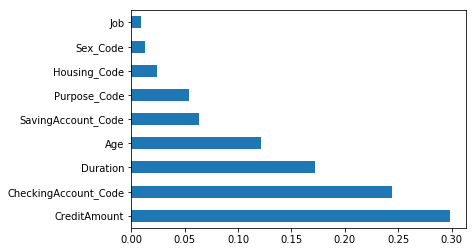

In [296]:
import pandas as pd
import numpy as np
model = GradientBoostingClassifier()
model.fit(rescaledX,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

<a id='6.3'></a>
## 7.3. Save Model for Later Use

In [304]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [308]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
result = accuracy_score(Y_validation, predictions)
print(result)

0.765
